In [1]:
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

from data_processing import remove_xa0_and_convert_to_int64

In [2]:
df_takeoff = pd.read_csv('data/M1_final.csv')

### Data Cleaning

In [3]:
# Plane ID has no effect
df_takeoff = df_takeoff.drop(columns='TAIL_NUM')

In [4]:
# Remove the two NaNs
df_takeoff = df_takeoff.dropna()

# Confirm there are no NaNs
df_takeoff.isna().sum()

MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
DEST                 0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
CRS_DEP_M            0
DEP_TIME_M           0
CRS_ARR_M            0
Temperature          0
Dew Point            0
Humidity             0
Wind                 0
Wind Speed           0
Wind Gust            0
Pressure             0
Condition            0
sch_dep              0
sch_arr              0
TAXI_OUT             0
dtype: int64

In [5]:
# Fix formatting of Dew Point column
df_takeoff['Dew Point'] = df_takeoff['Dew Point'].apply(remove_xa0_and_convert_to_int64)

# Check Dew Point column formatting
df_takeoff['Dew Point'].head()

0    34
1    34
2    34
3    34
4    32
Name: Dew Point, dtype: int64

In [6]:
df_takeoff.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,CHS,-1,124,636,324,323,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,LAX,-7,371,2475,340,333,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,FLL,40,181,1069,301,341,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,MCO,-2,168,944,345,343,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,ATL,-4,139,760,360,356,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


### Preprocessing Pipeline

In [7]:
class WeatherConditionEncoder(BaseEstimator, TransformerMixin):
    """
    A class to conver a combined condition into a truth 
    table of separated conditions. e.g.:
    ```
                    Wind    Snow    Rain
    Wind and Rain   1.0     0.0     1.0
    Snow            0.0     1.0     0.0
    Wind and Snow   1.0     1.0     0.0
    ```
    """
    def transform(self, X: pd.Series, y=None):
        # Create a list of unique weather conditions 
        # (instead of combinations of conditions)
        separated = []
        for conditions in X.unique():
            for cond in conditions.split(' / '):
                separated.append(cond)
        separated = list(set(separated))

        # One column has 'and' instead of '/' so we need split that
        # too and then remove it from the list of separated conditions 
        remove = []
        for cond in separated:
            if 'and' in cond:
                remove.append(cond)
                for c in cond.split(' and '):
                    separated.append(c)
        for cond in remove:
            separated.remove(cond)
        
        # Encode the separated conditions into a truth table
        encoded = pd.DataFrame(
            np.zeros((X.shape[0], len(separated))),
            columns=separated
        )
        for r, row in enumerate(X):
            for c, cond in enumerate(separated):
                if cond in row:
                    encoded.iloc[r, c] = 1.0
        return encoded


expander = WeatherConditionEncoder()
expander.transform(df_takeoff['Condition'])

,Cloudy,Snow,Windy,Light Drizzle,Fog,Partly Cloudy,Light Rain,Light Snow,Heavy Rain,Mostly Cloudy,Fair,Light Freezing Rain,Rain,Wintry Mix,Drizzle,Fog
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28813,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28814,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28815,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28816,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
RANDOM_STATE = 42

In [9]:
X = df_takeoff.drop(columns=['TAXI_OUT'])
y = df_takeoff['TAXI_OUT']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [11]:
numeric_cols = X.select_dtypes(['int64', 'float64']).columns.to_numpy()
categoric_cols = X.select_dtypes(['object']).columns.to_list()

In [12]:
standard_scale_cols = numeric_cols[(numeric_cols != 'DEP_DELAY') & (numeric_cols != 'sch_arr') & (numeric_cols != 'CRS_ELAPSED_TIME')]

col_transformer = ColumnTransformer(
    [
        (
            'Quantile',
            QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE),
            ['DEP_DELAY', 'sch_arr', 'CRS_ELAPSED_TIME']
        ),
        ('Standard', StandardScaler(), standard_scale_cols),
        ('Categorical', OneHotEncoder(), categoric_cols)
    ]
)

### Evaluate a Model

In [13]:
def evaluate_cv(
    model, X_train, y_train, n_splits: int = 5, 
    scoring: str = 'neg_root_mean_squared_error',
    random_state=42
) -> dict:
    k_fold = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    return cross_validate(
        model,
        X_train,
        y_train,
        cv=k_fold,
        scoring=scoring,
        n_jobs=-1
    )


def print_cv_results(cv_results) -> None:
    rmse = -cv_results['test_score']
    fit_time = cv_results['fit_time']
    print('CV Results')
    print(f'rmse: {rmse.mean():.5f} +/- {rmse.std():.5f}')
    print(f'training time: {fit_time.mean():.2f}s +/- {fit_time.std():.2f}s')

In [24]:
# model = Ridge()
model = xgb.XGBRegressor()
X_train_scaled = col_transformer.fit_transform(X_train)

cv_result = evaluate_cv(
    model, X_train_scaled, y_train, 
    random_state=RANDOM_STATE
)

print_cv_results(cv_result)

CV Results
rmse: 5.86737 +/- 0.04524
training time: 1.42s +/- 0.11s


In [25]:
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
X_test_scaled = col_transformer.transform(X_test)
y_pred = model.predict(X_test_scaled)

### Log Metrics

In [27]:
# Setup MLflow tracking
mlflow.set_tracking_uri('http://localhost:5000')
experiment_name = 'JFK Taxi Out'
mlflow.set_experiment(experiment_name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

In [28]:
with mlflow.start_run(
        experiment_id=experiment.experiment_id, 
        run_name='xgb_default'
    ):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse}')
    print(f'R2  : {r2}')

    mlflow.sklearn.log_model(model, 'sk_models')
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('R2_Score', r2)

fluent 438915687642910146
RMSE: 5.758943975259927
R2  : 0.29618774347228405


<Axes: xlabel='y_true', ylabel='y_pred'>

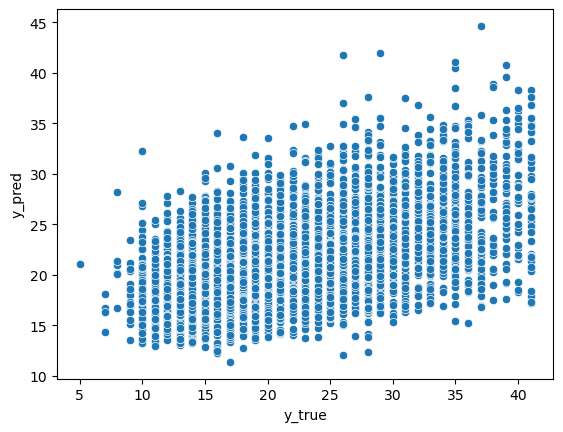

In [29]:
results = pd.DataFrame(
    {'y_true': y_test, 'y_pred': y_pred}
)
sns.scatterplot(x=results['y_true'], y=results['y_pred'])